In [53]:
import sys
print(sys.version)

3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]


In [96]:
import numpy as np
import pickle
import gzip
import random
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

## Task 1: Implement the Feedforward Neural Network (3 layers)

### old version with +1 bias

In [109]:
class NeuralNetwork:
    """
    A feedforward neural network with 3 layers (input, hidden, output).
    Uses sigmoid activation function and implements backpropagation with SGD.
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """
        Initialize the neural network.
        
        Args:
            input_size: Number of input neurons (784 + 1 for bias)
            hidden_size: Number of hidden neurons (30 + 1 for bias)  
            output_size: Number of output neurons (10)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weights with random values
        # Weights from input to hidden layer (including bias)
        self.weights_input_hidden = np.random.randn(hidden_size - 1, input_size) * 0.1
        
        # Weights from hidden to output layer (including bias)
        self.weights_hidden_output = np.random.randn(output_size, hidden_size) * 0.1
        
        # Store training history
        self.training_history = []
        
    @staticmethod
    def sigmoid(z: np.ndarray) -> np.ndarray:
        """Sigmoid activation function."""
        # Clip z to prevent overflow
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))
    
    @staticmethod
    def sigmoid_derivative(z: np.ndarray) -> np.ndarray:
        """Derivative of sigmoid function."""
        s = NeuralNetwork.sigmoid(z)
        return s * (1 - s)

New Version of Task 1: uses separate bias parameters per layer (not +1 neuron) and supports multiple hidden layers

In [111]:
class NeuralNetwork:
    def __init__(self, *sizes, seed=42):
        """
        Initialize a feedforward neural network.

        Args:
            *sizes: either multiple integers (e.g. 784, 30, 10)
                    or a single list/tuple (e.g. [784, 30, 10])
            seed: random seed for reproducibility
        """
        # Allow both styles of input: list/tuple or multiple args
        if len(sizes) == 1 and isinstance(sizes[0], (list, tuple)):
            self.sizes = [int(s) for s in sizes[0]]
        else:
            self.sizes = [int(s) for s in sizes]

        rng = np.random.default_rng(seed)  # random generator with fixed seed

        # Initialize weights for each layer connection
        # weights[l] has shape (size of layer l+1, size of layer l)
        self.weights = [
            rng.normal(0.0, 0.1, size=(self.sizes[l+1], self.sizes[l]))
            for l in range(len(self.sizes) - 1)
        ]

        # Initialize biases for each non-input layer
        # biases[l] has shape (size of layer l+1, 1)
        self.biases = [
            np.zeros((self.sizes[l+1], 1)) 
            for l in range(len(self.sizes) - 1)
        ]

    @staticmethod
    def sigmoid(z):
        """
        Sigmoid activation function.
        Clips input values to avoid overflow in exp().
        """
        z = np.clip(z, -500, 500)  # numerical stability
        return 1.0 / (1.0 + np.exp(-z))

    @staticmethod
    def sigmoid_derivative(z):
        """
        Derivative of the sigmoid function.
        Useful in backpropagation for gradient calculation.
        """
        s = NeuralNetwork.sigmoid(z)
        return s * (1 - s)

    @staticmethod
    def softmax(z):
        """
        Softmax activation function for output layer.
        Converts logits into probabilities that sum to 1.
        """
        z = z - np.max(z, axis=0, keepdims=True)  # stability trick
        exp_vals = np.exp(z)
        return exp_vals / np.sum(exp_vals, axis=0, keepdims=True)

## Task 2: Reading the MNIST Data

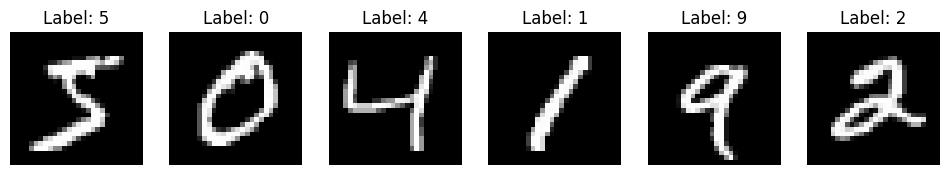

Data loaded and preprocessed successfully!
Training samples: 50000
Validation samples: 10000
Test samples: 10000


In [127]:
class MNISTLoader:
    @staticmethod
    def load_data(filename: str = 'mnist.pkl.gz') -> Tuple[Tuple, Tuple, Tuple]:
        """Load MNIST data from pickle file."""
        with gzip.open(filename, 'rb') as f:
            training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
        return training_data, validation_data, test_data
    
    @staticmethod
    def preprocess_data(raw_data: Tuple) -> List[Tuple[np.ndarray, np.ndarray]]:
        """Add bias term and one-hot encode labels."""
        # If labels[i] == 3, then → [0,0,0,1,0,0,0,0,0,0]
        # If labels[i] == 7, then → [0,0,0,0,0,0,0,0,1,0]
        inputs, labels = raw_data
        processed_data = []
        for i in range(len(inputs)):
            x = inputs[i].astype(np.float64)          # shape (784,)
            y = np.zeros(10, dtype=np.float64)
            y[labels[i]] = 1.0                        # one-hot
            processed_data.append((x, y))
        return processed_data

    @staticmethod
    def visualize_samples(raw_data: Tuple, num_samples: int = 6):
        """Quickly visualize a few samples."""
        inputs, labels = raw_data
        fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
        for i in range(num_samples):
            axes[i].imshow(inputs[i].reshape(28, 28), cmap='gray')
            axes[i].set_title(f'Label: {labels[i]}')
            axes[i].axis('off')
        plt.show()

# Example usage
if __name__ == "__main__":
    training_raw, validation_raw, test_raw = MNISTLoader.load_data('mnist.pkl.gz')
    
    # Preprocess
    training_data = MNISTLoader.preprocess_data(training_raw)
    validation_data = MNISTLoader.preprocess_data(validation_raw)
    test_data = MNISTLoader.preprocess_data(test_raw)

    # Show a few images
    MNISTLoader.visualize_samples(training_raw, 6)

    print("Data loaded and preprocessed successfully!")
    print(f"Training samples: {len(training_data)}")
    print(f"Validation samples: {len(validation_data)}")
    print(f"Test samples: {len(test_data)}")

784 is the flattened image size (28x28 pixels). 
Normalization means Dividing the pixel values by 255.0 converts them to a scale between 0 and 1. and One-hot encoding ensures the labels are in a format suitable for training a neural network. For example, the label 5 will be converted to [0, 0, 0, 0, 0, 1, 0, 0, 0, 0].

## Task 3:  Implement Stochastic Gradient Descent

#### In SGD, backpropagation is used to calculate the gradients, which are then used to update the weights and minimize the loss. thats why, Task 3 cannot work without Task 4 because they’re intertwined. SGD is the high-level process, and backpropagation is the core mechanism that allows SGD to update the weights.

#### Task 3 focuses on training the neural network using mini-batch gradient descent (SGD). This involves iterating over mini-batches of data, performing forward propagation, calculating the loss, and updating the weights using the gradient (calculated from backpropagation). Task 4 focuses on calculating the gradients using the backpropagation algorithm, which is required to update the weights in Task 3 (SGD).

#### Implement the Backpropagation Algorithm (calculating the gradients (derivatives) of the loss function with respect to the weights and biases of the network. These gradients are then used by SGD to update the weights.)

sigmoid on hidden + softmax on output

In [113]:
def feedforward(self, x: np.ndarray):
    """
    Forward pass through the network.
    Hidden layers: sigmoid
    Output layer: softmax
    """
    a = np.asarray(x, dtype=np.float64).reshape(self.sizes[0], 1)
    activations = [a]
    zs = []

    # hidden layers
    for l in range(len(self.sizes) - 2):
        z = self.weights[l] @ a + self.biases[l]
        a = self.sigmoid(z)
        zs.append(z)
        activations.append(a)

    # output layer
    zL = self.weights[-1] @ a + self.biases[-1]
    aL = self.softmax(zL)   # <-- softmax here
    zs.append(zL)
    activations.append(aL)

    return activations, zs

## Task 4: Implement the Backpropagation Algorithm 

In [114]:
def backpropagation(self, x: np.ndarray, y: np.ndarray):
    """
    Backpropagation with cross-entropy loss and softmax output.
    """
    activations, zs = self.feedforward(x)
    y = np.asarray(y, dtype=np.float64).reshape(self.sizes[-1], 1)

    dW = [np.zeros_like(W) for W in self.weights]
    db = [np.zeros_like(b) for b in self.biases]

    # Output error (softmax + cross-entropy): delta = a_L - y
    delta = activations[-1] - y
    dW[-1] = delta @ activations[-2].T
    db[-1] = delta

    # Hidden layers: sigmoid derivative
    for l in range(len(self.sizes) - 2, 0, -1):
        delta = (self.weights[l].T @ delta) * self.sigmoid_derivative(zs[l-1])
        dW[l-1] = delta @ activations[l-1].T
        db[l-1] = delta

    return dW, db

## Task 5: Train Neural Network

multi-layer class (self.sizes, self.weights, self.biases) and using Softmax + Cross-Entropy
---old update_mini_batch only updated two matrices (weights_input_hidden, weights_hidden_output). This new version updates all layers using the lists self.weights / self.biases.

In [115]:
# --- TRAINING (SGD) -------------------------------------------------
def train_sgd(
    self,
    training_data: List[Tuple[np.ndarray, np.ndarray]],
    epochs: int,
    mini_batch_size: int,
    learning_rate: float,
    validation_data: Optional[List[Tuple[np.ndarray, np.ndarray]]] = None,
):
    """Train the network using Stochastic Gradient Descent."""
    n_train = len(training_data)
    self.training_history = []

    for epoch in range(epochs):
        random.shuffle(training_data)
        mini_batches = [
            training_data[k:k + mini_batch_size]
            for k in range(0, n_train, mini_batch_size)
        ]

        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, learning_rate)

        # quick evaluation (use a subset for speed if you like)
        sample = training_data[: min(1000, len(training_data))]
        train_accuracy = self.evaluate(sample)
        train_loss = self.compute_loss(sample)

        results = {
            "epoch": epoch + 1,
            "train_accuracy": train_accuracy,
            "train_loss": train_loss,
        }

        if validation_data:
            val_accuracy = self.evaluate(validation_data)
            val_loss = self.compute_loss(validation_data)
            results["val_accuracy"] = val_accuracy
            results["val_loss"] = val_loss
            print(
                f"Epoch {epoch+1}: "
                f"Train Acc: {train_accuracy:.2%}, Val Acc: {val_accuracy:.2%}, "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
            )
        else:
            print(
                f"Epoch {epoch+1}: Train Acc: {train_accuracy:.2%}, "
                f"Train Loss: {train_loss:.4f}"
            )

        self.training_history.append(results)

# --- ONE MINI-BATCH STEP --------------------------------------------
def update_mini_batch(
    self,
    mini_batch: List[Tuple[np.ndarray, np.ndarray]],
    learning_rate: float,
):
    """Accumulate gradients over a mini-batch and update all layers."""
    # initialize accumulators (same shapes as weights/biases)
    grad_w = [np.zeros_like(W) for W in self.weights]
    grad_b = [np.zeros_like(b) for b in self.biases]

    for x, y in mini_batch:
        dW, dB = self.backpropagation(x, y)  # must return lists, one per layer
        for l in range(len(self.weights)):
            grad_w[l] += dW[l]
            grad_b[l] += dB[l]

    m = len(mini_batch)
    eta = learning_rate / m
    # gradient step for every layer
    for l in range(len(self.weights)):
        self.weights[l] -= eta * grad_w[l]
        self.biases[l]  -= eta * grad_b[l]

# --- PREDICT / EVALUATE ---------------------------------------------
def predict(self, x: np.ndarray) -> int:
    """Return argmax class for a single sample."""
    activations, _ = self.feedforward(x)
    probs = activations[-1]                 # softmax output
    return int(np.argmax(probs))

def evaluate(self, data: List[Tuple[np.ndarray, np.ndarray]]) -> float:
    """Accuracy on a dataset of (x, one-hot y)."""
    correct = 0
    for x, y in data:
        if self.predict(x) == int(np.argmax(y)):
            correct += 1
    return correct / len(data)

# --- LOSS (CROSS-ENTROPY) -------------------------------------------
def compute_loss(self, data: List[Tuple[np.ndarray, np.ndarray]]) -> float:
    """Mean cross-entropy over a dataset (with softmax output)."""
    eps = 1e-12
    total = 0.0
    for x, y in data:
        activations, _ = self.feedforward(x)
        p = np.clip(activations[-1], eps, 1.0)     # softmax probs
        y_vec = np.asarray(y, dtype=float).reshape(-1, 1)
        total += float(-np.sum(y_vec * np.log(p))) # CE for one sample
    return total / len(data)

old training" update_mini_batch only updated two matrices (weights_input_hidden, weights_hidden_output). The new version (up) updates all layers using the lists self.weights / self.biases.

## Task 6: Output Learning Success per Epoch

Input normalization:
Usually MNIST pixel values are between 0–255. It’s standard to scale them to [0,1]. If the mnist.pkl.gz already has normalized data (sometimes it does), then we’re fine. If not, we should add: inputs = inputs / 255 before appending.

In [117]:
class MNISTLoader:
    """Utility class for loading and preprocessing MNIST data."""
    
    @staticmethod
    def load_data(filename: str) -> Tuple[
        Tuple[np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray],
        Tuple[np.ndarray, np.ndarray]
    ]:
        """Load MNIST data from pickle file."""
        try:
            with gzip.open(filename, 'rb') as f:
                training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
            return training_data, validation_data, test_data
        except FileNotFoundError:
            print(f"File {filename} not found. Please ensure the MNIST data file is in the correct location.")
            return None, None, None
    
    @staticmethod
    def preprocess_data(raw_data: Tuple[np.ndarray, np.ndarray]) -> List[Tuple[np.ndarray, np.ndarray]]:
        """
        Preprocess MNIST data for neural network.
        
        Args:
            raw_data: Tuple of (inputs, labels)
            
        Returns:
            List of (input_with_bias, one_hot_label) tuples
        """
        inputs, labels = raw_data
        processed_data = []
        
        for i in range(len(inputs)):
            # Normalize pixels (if not already normalized)
            x = inputs[i] / 255.0 if inputs[i].max() > 1 else inputs[i]
            
            # Add bias term (shape: 785x1 column vector)
            input_with_bias = np.concatenate([x, [1.0]]).reshape(-1, 1)
            
            # Convert label to one-hot encoding (shape: 10x1 column vector)
            one_hot = np.zeros((10, 1))
            one_hot[labels[i]] = 1.0
            
            processed_data.append((input_with_bias, one_hot))
        
        return processed_data

## Task 7: Implement an Attack on the Trained Network

Not using random placeholder gradient, its FGSM. compute ∂loss/∂x. compute the true input-gradient via backprop and then perturb the image.

In [119]:
class AdversarialAttack:
    """Adversarial attacks for our NeuralNetwork."""

    @staticmethod
    def _forward_cache(model, x):
        """Run a forward pass and keep all z and a for backprop-to-input."""
        a = x.astype(float)
        activations = [a]           # a^0 .. a^L
        zs = []                     # z^1 .. z^L

        L = len(model.weights)
        for l in range(L):
            z = model.weights[l] @ a + model.biases[l]
            zs.append(z)
            if l < L - 1:
                a = model.sigmoid(z)
            else:
                # Output layer: prefer softmax if available
                if hasattr(model, "softmax"):
                    a = model.softmax(z)
                else:
                    a = model.sigmoid(z)
            activations.append(a)
        return activations, zs

    @staticmethod
    def _delta_L(model, a_L, y, z_L):
        """
        Output-layer error term.
        - If softmax + cross-entropy: delta^L = a_L - y (no z term)
        - Else (sigmoid + quadratic): delta^L = (a_L - y) * sigma'(z_L)
        """
        if hasattr(model, "softmax"):
            return (a_L - y)  # cross-entropy + softmax
        else:
            return (a_L - y) * model.sigmoid_derivative(z_L)

    @staticmethod
    def fgsm_attack(model, x: np.ndarray, y: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        """
        True FGSM: x_adv = x + ε * sign(∂loss/∂x)
        Expects x shape (n_features, 1) with last entry being the bias 1.0 (we won't perturb bias).
        """
        # ---- forward (cache all to backprop to input) ----
        activations, zs = AdversarialAttack._forward_cache(model, x)

        # ---- backprop deltas to input ----
        L = len(model.weights)
        deltas = [None] * L

        # output delta
        deltas[-1] = AdversarialAttack._delta_L(model, activations[-1], y, zs[-1])

        # hidden deltas (L-1 .. 1)
        for l in range(L - 2, -1, -1):
            if l == L - 2:
                W_next = model.weights[l + 1]
            else:
                W_next = model.weights[l + 1]
            deltas[l] = (W_next.T @ deltas[l + 1]) * model.sigmoid_derivative(zs[l])

        # gradient wrt input is W^0^T @ delta^1
        grad_x = model.weights[0].T @ deltas[0]  # shape (n_input, 1)

        # do not perturb the bias dimension (last row)
        grad_x[-1, 0] = 0.0

        # ---- FGSM perturbation ----
        perturb = epsilon * np.sign(grad_x)
        x_adv = x + perturb

        # clip only the pixel part (exclude bias at end)
        x_adv[:-1] = np.clip(x_adv[:-1], 0.0, 1.0)
        return x_adv

    @staticmethod
    def random_noise_attack(x: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        """Simple random noise (for baselines)."""
        noise = np.random.normal(0, epsilon, x.shape)
        noise[-1, 0] = 0.0  # keep bias untouched
        x_noisy = x + noise
        x_noisy[:-1] = np.clip(x_noisy[:-1], 0.0, 1.0)
        return x_noisy

    @staticmethod
    def evaluate_under_attack(model, data, epsilon=0.1):
        """Utility: accuracy on FGSM-perturbed test set."""
        correct = 0
        for x, y in data:
            x_adv = AdversarialAttack.fgsm_attack(model, x, y, epsilon=epsilon)
            pred = model.predict(x_adv)
            if pred == int(np.argmax(y)):
                correct += 1
        return correct / len(data)

## Main execution code

MNIST Neural Network Project

Training: epochs=10, batch_size=32, lr=0.5
Epoch 01 | Train 88.45% | Val 89.76% | Loss 0.1177 | ValLoss 0.1067
Epoch 02 | Train 90.75% | Val 91.54% | Loss 0.0819 | ValLoss 0.0755
Epoch 03 | Train 91.80% | Val 92.37% | Loss 0.0714 | ValLoss 0.0658
Epoch 04 | Train 91.50% | Val 93.05% | Loss 0.0746 | ValLoss 0.0602
Epoch 05 | Train 93.80% | Val 93.44% | Loss 0.0578 | ValLoss 0.0564
Epoch 06 | Train 92.95% | Val 93.62% | Loss 0.0590 | ValLoss 0.0541
Epoch 07 | Train 94.40% | Val 93.72% | Loss 0.0509 | ValLoss 0.0519
Epoch 08 | Train 94.85% | Val 94.37% | Loss 0.0460 | ValLoss 0.0494
Epoch 09 | Train 94.35% | Val 94.43% | Loss 0.0518 | ValLoss 0.0489
Epoch 10 | Train 95.35% | Val 94.50% | Loss 0.0438 | ValLoss 0.0469

Final Evaluation:
Training Accuracy (2k samp): 95.35%
Validation Accuracy:        94.50%
Test Accuracy:              94.36%

Baseline test accuracy:    94.36%
After random-noise attack: 87.00%
Accuracy change: -7.36%


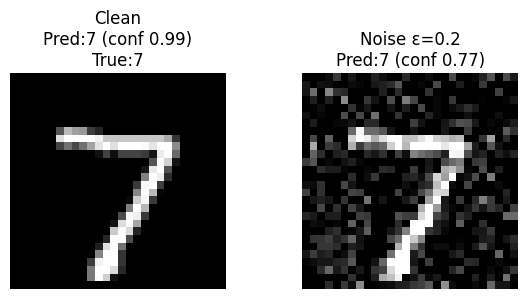


Done.


In [ ]:
# =========================
# Main execution code 
# =========================

def _aL(net, x):
    """
    Return last-layer activations (probabilities) regardless of the
    feedforward signature used in the class (new or legacy).
    """
    out = net.feedforward(x)
    if isinstance(out, tuple):
        if len(out) == 2:              # new: (activations, zs)
            activations, _ = out
            return activations[-1]
        elif len(out) >= 4:            # old: (..., output_output)
            return out[3]
    # fallback: assume out is already the final activations
    return out

def main():
    print("MNIST Neural Network Project")
    print("=" * 40)

    # ---- Load & preprocess ----
    loader = MNISTLoader()
    raw_train, raw_val, raw_test = loader.load_data('mnist.pkl.gz')
    if raw_train is None:
        print("Failed to load data. Check path to 'mnist.pkl.gz'.")
        return

    # IMPORTANT: preprocess_data must NOT append a bias now (keep x shape = 784)
    train_data = loader.preprocess_data(raw_train)   # [(x:784,), (y_onehot:10,)]
    val_data   = loader.preprocess_data(raw_val)
    test_data  = loader.preprocess_data(raw_test)

    # ---- Build network ----
    # You can add more hidden layers, e.g. NeuralNetwork(784, 64, 32, 10)
    net = NeuralNetwork(784, 31, 10)

    # ---- Train (fast config) ----
    EPOCHS = 10
    BATCH  = 32
    LR     = 0.5
    print(f"\nTraining: epochs={EPOCHS}, batch_size={BATCH}, lr={LR}")
    net.train_sgd(
        training_data=train_data,
        epochs=EPOCHS,
        mini_batch_size=BATCH,
        learning_rate=LR,
        validation_data=val_data
    )

    # ---- Final evaluation ----
    print("\nFinal Evaluation:")
    train_acc = net.evaluate(train_data[:2000])  # subset for speed
    val_acc   = net.evaluate(val_data)
    test_acc  = net.evaluate(test_data)
    print(f"Training Accuracy (2k samp): {train_acc:.2%}")
    print(f"Validation Accuracy:        {val_acc:.2%}")
    print(f"Test Accuracy:              {test_acc:.2%}")

    # ---- Quick noise-attack demo (simple & fast) ----
    def noise_attack_sample(x, eps=0.2):
        noise = np.random.normal(0, eps, size=x.shape)
        return np.clip(x + noise, 0.0, 1.0)

    baseline = net.evaluate(test_data)
    attacked = [(noise_attack_sample(x, 0.2), y) for (x, y) in test_data[:2000]]
    attacked_acc = net.evaluate(attacked)
    print(f"\nBaseline test accuracy:    {baseline:.2%}")
    print(f"After random-noise attack: {attacked_acc:.2%}")
    print(f"Accuracy change: {(attacked_acc - baseline):+.2%}")

    # ---- Visualize one clean vs attacked example ----
    idx = 0
    x_clean, y_true = test_data[idx]
    x_adv, _ = attacked[idx]

    pred_clean = net.predict(x_clean)
    conf_clean = float(_aL(net, x_clean)[pred_clean])

    pred_adv   = net.predict(x_adv)
    conf_adv   = float(_aL(net, x_adv)[pred_adv])

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(x_clean.reshape(28, 28), cmap='gray')
    axes[0].set_title(f"Clean\nPred:{pred_clean} (conf {conf_clean:.2f})\nTrue:{int(np.argmax(y_true))}")
    axes[0].axis('off')

    axes[1].imshow(x_adv.reshape(28, 28), cmap='gray')
    axes[1].set_title(f"Noise ε=0.2\nPred:{pred_adv} (conf {conf_adv:.2f})")
    axes[1].axis('off')
    plt.tight_layout(); plt.show()

    print("\nDone.")
    return net, train_data, val_data, test_data


# ---------- Script entry ----------
if __name__ == "__main__":
    network, train_data, val_data, test_data = main()

### Plot training/validation accuracy and loss curves.


Plotting training history...


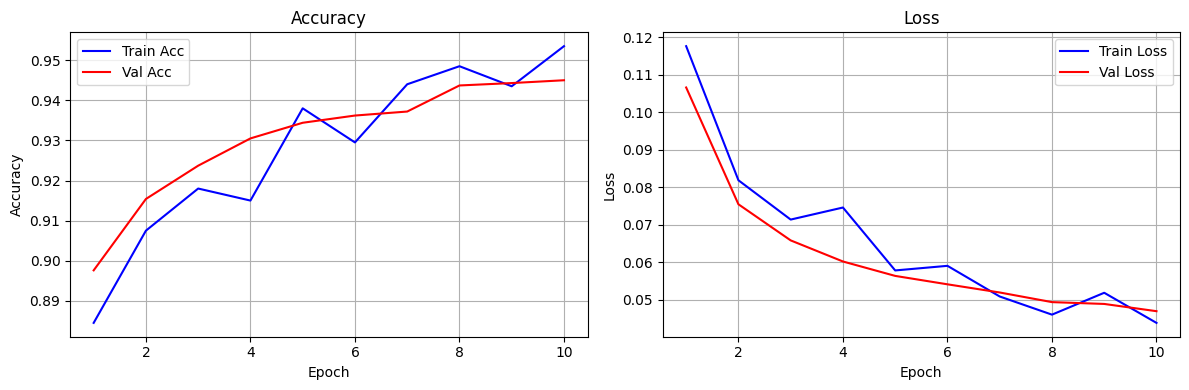

In [132]:
def plot_history(network):
    if not network.training_history:
        print("No training history to plot.")
        return
    
    epochs = [h['epoch'] for h in network.training_history]
    train_acc = [h['train_accuracy'] for h in network.training_history]
    train_loss = [h['train_loss'] for h in network.training_history]

    # Some runs may not include validation
    val_acc  = [h.get('val_accuracy', None) for h in network.training_history]
    val_loss = [h.get('val_loss', None) for h in network.training_history]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy curve
    ax1.plot(epochs, train_acc, label="Train Acc", color='blue')
    if any(v is not None for v in val_acc):
        ax1.plot(epochs, val_acc, label="Val Acc", color='red')
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    # Loss curve
    ax2.plot(epochs, train_loss, label="Train Loss", color='blue')
    if any(v is not None for v in val_loss):
        ax2.plot(epochs, val_loss, label="Val Loss", color='red')
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("\nPlotting training history...")
plot_history(network)

### small sample testing

In [139]:
def _aL(net, x):
    """Return last-layer activations (probabilities) regardless of feedforward style."""
    out = net.feedforward(x)
    # New style: (activations, zs)
    if isinstance(out, tuple) and len(out) == 2:
        return out[0][-1].ravel()
    # Old style: (..., output_output)
    if isinstance(out, tuple) and len(out) >= 4:
        return out[3].ravel()
    # Fallback: assume out already is a_L
    return np.asarray(out).ravel()

def test_network_on_samples(network, data, num_samples: int = 10):
    """Quick sample test: prediction, confidence, correctness."""
    num_samples = min(num_samples, len(data))
    print(f"\nTesting network on {num_samples} samples:")
    print("-" * 40)
    correct = 0
    for i in range(num_samples):
        x, y = data[i]
        pred = network.predict(x)
        probs = _aL(network, x)
        conf = float(probs[pred])
        true = int(np.argmax(y))
        ok = (pred == true)
        correct += int(ok)
        print(f"#{i+1}: Pred {pred} (conf {conf:.2f}) | True {true} | {'✓' if ok else '✗'}")
    print(f"\nSample accuracy: {correct/num_samples:.2%}")

 
try:
    network
    test_data
except NameError:
    network, train_data, val_data, test_data = main()

# Run the quick test
test_network_on_samples(network, test_data, num_samples=10)


Testing network on 10 samples:
----------------------------------------
#1: Pred 7 (conf 0.99) | True 7 | ✓
#2: Pred 2 (conf 0.90) | True 2 | ✓
#3: Pred 1 (conf 0.96) | True 1 | ✓
#4: Pred 0 (conf 0.99) | True 0 | ✓
#5: Pred 4 (conf 0.96) | True 4 | ✓
#6: Pred 1 (conf 0.98) | True 1 | ✓
#7: Pred 4 (conf 0.89) | True 4 | ✓
#8: Pred 9 (conf 0.93) | True 9 | ✓
#9: Pred 6 (conf 0.85) | True 5 | ✗
#10: Pred 9 (conf 0.95) | True 9 | ✓

Sample accuracy: 90.00%


#### The loss values are steadily decreasing, that means the network is learning and the training is progressing. 
    1.	Shuffling the Data: The training data is shuffled at the start of each epoch to ensure that the model doesn’t learn any bias from the order of the data.
	2.	Mini-batch Gradient Descent: divide the data into smaller batches (mini-batches) and update the weights after processing each mini-batch.
	3.	Forward Pass: The forward() method of the neural network is used to calculate the network’s output.
	4.	Loss Calculation: compute the quadratic loss (sum of squared errors) between the predicted output and the actual labels for the mini-batch.
	5.	Backpropagation: used to compute the gradients (derivatives of the loss with respect to weights and biases) and adjust the weights accordingly.
	6.	Weight Update: The weights and biases are updated by subtracting the gradients scaled by the learning rate.


# Rest of the code is trash/messy, so just look at the above project 1 which is complete up until here.

## Extension

## Task 2a: compare 4-bit output vs 10-class output

### 10 outputs (softmax + cross-entropy): classic.
### 4 outputs (bitwise): use sigmoid + BCE on each bit. Then decode 4 bits → class (0–15) and mask to 0–9 (we only need 0–9).

In [90]:
def to_4bit_labels(y_int: np.ndarray) -> np.ndarray:
    """Convert digit labels (0..9) to 4-bit vectors."""
    n = len(y_int)
    Y4 = np.zeros((n, 4), dtype=np.float32)
    for i, val in enumerate(y_int):
        bits = [(val >> b) & 1 for b in range(4)]  # little endian
        Y4[i] = bits[::-1]                         # big endian (b3 b2 b1 b0)
    return Y4

def from_4bit_bits(B4: np.ndarray) -> np.ndarray:
    """Convert 4-bit predictions (0/1) to class ints."""
    # B4 shape (N,4) with 0/1; decode MSB..LSB
    bits = (B4 > 0.5).astype(int)
    vals = bits[:,0]*8 + bits[:,1]*4 + bits[:,2]*2 + bits[:,3]*1
    # map 10..15 back to nearest (or clamp) — here we’ll clamp to 9
    vals = np.clip(vals, 0, 9)
    return vals

# Prepare 10-class and 4-bit datasets
with gzip.open("mnist.pkl.gz","rb") as f:
    (Xtr_i, ytr_i), (Xval_i, yval_i), (Xte_i, yte_i) = pickle.load(f, encoding="latin1")
Xtr = np.asarray([x[:-1] for x in Xtr_i]).astype(np.float32)
Xval = np.asarray([x[:-1] for x in Xval_i]).astype(np.float32)
Xte  = np.asarray([x[:-1] for x in Xte_i]).astype(np.float32)

# 10-way one-hot (already used above as train_Y/val_Y/test_Y if you prefer)
def one_hot(y, k=10):
    Z = np.zeros((len(y), k), dtype=np.float32); Z[np.arange(len(y)), y]=1; return Z
Ytr10, Yval10, Yte10 = one_hot(ytr_i), one_hot(yval_i), one_hot(yte_i)

# 4-bit labels
Ytr4, Yval4, Yte4 = to_4bit_labels(ytr_i), to_4bit_labels(yval_i), to_4bit_labels(yte_i)

# Train 10-output model
mlp10 = ExtendedMLP([Xtr.shape[1], 30, 10], hidden_activation="sigmoid", output_activation="softmax", loss="cross_entropy")
mlp10.fit(Xtr, Ytr10, epochs=5, batch_size=64, lr=0.2, X_val=Xval, Y_val=Yval10)
acc10 = mlp10.score(Xte, Yte10)
print("10-output test acc:", acc10)

# Train 4-output bitwise model (sigmoid + BCE)
mlp4 = ExtendedMLP([Xtr.shape[1], 30, 4], hidden_activation="sigmoid", output_activation="sigmoid", loss="bce")
mlp4.fit(Xtr, Ytr4, epochs=5, batch_size=64, lr=0.2, X_val=Xval, Y_val=Yval4)

# Evaluate 4-bit model by decoding bits
probs4, _ = mlp4.forward(Xte)
pred_digits = from_4bit_bits(probs4)
acc4 = float(np.mean(pred_digits == yte_i))
print("4-output (bitwise) decoded test acc:", acc4)

Epoch 01 | Train 89.51% loss 0.3811 | Val 90.56% loss 0.3506
Epoch 02 | Train 91.57% loss 0.2986 | Val 92.06% loss 0.2793
Epoch 03 | Train 92.62% loss 0.2582 | Val 93.00% loss 0.2444
Epoch 04 | Train 93.25% loss 0.2351 | Val 93.55% loss 0.2267
Epoch 05 | Train 93.93% loss 0.2122 | Val 94.18% loss 0.2070
10-output test acc: 0.9385
Epoch 01 | Train 49.64% loss 0.3537 | Val 49.54% loss 0.3450
Epoch 02 | Train 52.87% loss 0.2969 | Val 52.70% loss 0.2864
Epoch 03 | Train 53.09% loss 0.2656 | Val 52.80% loss 0.2551
Epoch 04 | Train 55.20% loss 0.2428 | Val 54.93% loss 0.2331
Epoch 05 | Train 58.30% loss 0.2241 | Val 58.07% loss 0.2154
4-output (bitwise) decoded test acc: 0.8007


### Task 3a: Any activation function can be used

In [ ]:
import gzip, pickle, math, random
from typing import List, Tuple, Dict, Callable, Optional

# ---------- Any activation function  (Task 3) ----------
class Activations:
    @staticmethod
    def sigmoid(x): return 1/(1+np.exp(-x))
    @staticmethod
    def d_sigmoid(a): return a*(1-a)          # derivative via activation

    @staticmethod
    def tanh(x): return np.tanh(x)
    @staticmethod
    def d_tanh(a): return 1 - a**2

    @staticmethod
    def relu(x): return np.maximum(0, x)
    @staticmethod
    def d_relu(a): return (a > 0).astype(a.dtype)  # using post-activation a

    @staticmethod
    def leaky_relu(x, alpha=0.01): return np.where(x>0, x, alpha*x)
    @staticmethod
    def d_leaky_relu(a, alpha=0.01): return np.where(a>0, 1.0, alpha)

    @staticmethod
    def softmax(x):
        x = x - np.max(x, axis=-1, keepdims=True)
        e = np.exp(x)
        return e / np.sum(e, axis=-1, keepdims=True)

ACTIVATIONS: Dict[str, Tuple[Callable, Callable]] = {
    "sigmoid": (Activations.sigmoid, Activations.d_sigmoid),
    "tanh":    (Activations.tanh,    Activations.d_tanh),
    "relu":    (Activations.relu,    Activations.d_relu),
    "leaky_relu": (Activations.leaky_relu, Activations.d_leaky_relu),
    # output-only activations may override derivative handling inside the loss
    "softmax": (Activations.softmax, None),
}

## Task 4a: Choose loss functions differently from the square loss

In [87]:
# ---------- Choose loss functions differently from the square loss (Task 4) ----------
class Losses:
    @staticmethod
    def mse(y_pred, y_true):
        return 0.5*np.mean((y_pred - y_true)**2)

    @staticmethod
    def d_mse(y_pred, y_true, activation_name: str):
        # dL/dz = (y_pred - y_true) * f'(z) ; we pass f'(·) externally in backprop
        return (y_pred - y_true)

    @staticmethod
    def bce_logits(y_pred, y_true):
        # BCE with sigmoid outputs approximated using y_pred in (0,1)
        eps = 1e-12
        y_pred = np.clip(y_pred, eps, 1-eps)
        return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    @staticmethod
    def d_bce_logits(y_pred, y_true, activation_name: str):
        # With sigmoid output, dL/dz simplifies to (y_pred - y_true)
        return (y_pred - y_true)

    @staticmethod
    def cross_entropy(y_pred, y_true):
        # for one-hot and softmax output
        eps = 1e-12
        y_pred = np.clip(y_pred, eps, 1-eps)
        return -np.mean(np.sum(y_true*np.log(y_pred), axis=-1))

    @staticmethod
    def d_cross_entropy(y_pred, y_true, activation_name: str):
        # with softmax output, dL/dz = (y_pred - y_true)
        return (y_pred - y_true)

LOSSES: Dict[str, Tuple[Callable, Callable]] = {
    "mse":            (Losses.mse,            Losses.d_mse),
    "bce":            (Losses.bce_logits,     Losses.d_bce_logits),
    "cross_entropy":  (Losses.cross_entropy,  Losses.d_cross_entropy),
}

# ---------- Weight init helpers ----------
def xavier_init(fan_in, fan_out):
    std = math.sqrt(2.0/(fan_in+fan_out))
    return np.random.randn(fan_in, fan_out) * std

def he_init(fan_in, fan_out):
    std = math.sqrt(2.0/fan_in)
    return np.random.randn(fan_in, fan_out) * std

In [ ]:
# ---------- Extended MLP (Task 1 + 3 + 4) ----------
class ExtendedMLP:
    """
    A fully-connected MLP supporting:
      - arbitrary hidden layers (layer_sizes)
      - per-layer activations (hidden_activation, output_activation)
      - selectable losses
    Biases handled internally (no need to append +1 to inputs).
    """
    def __init__(self,
                 layer_sizes: List[int],                # e.g. [784, 30, 10]
                 hidden_activation: str = "sigmoid",
                 output_activation: str = "softmax",
                 loss: str = "cross_entropy",
                 seed: int = 42):
        assert len(layer_sizes) >= 2, "Need at least input and output size"
        self.layer_sizes = layer_sizes
        self.hidden_activation_name = hidden_activation
        self.output_activation_name = output_activation
        self.loss_name = loss
        self.rng = np.random.default_rng(seed)

        # pick activations
        self.act_h, self.d_act_h = ACTIVATIONS[hidden_activation]
        self.act_o, self.d_act_o = ACTIVATIONS[output_activation]
        self.loss_fn, self.d_loss = LOSSES[loss]

        # params: list of (W,b)
        self.W: List[np.ndarray] = []
        self.b: List[np.ndarray] = []
        for l in range(len(layer_sizes)-1):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l+1]
            if hidden_activation in ("relu", "leaky_relu") and l < len(layer_sizes)-2:
                Wl = he_init(fan_in, fan_out)
            else:
                Wl = xavier_init(fan_in, fan_out)
            bl = np.zeros((fan_out,))
            self.W.append(Wl)
            self.b.append(bl)

    # ------- forward pass (vectorized batch) -------
    def forward(self, X: np.ndarray):
        """
        X: (N, D)
        returns caches with pre/post activations for backprop
        """
        a = X
        caches = {"a0": a}
        # hidden layers
        for l in range(len(self.layer_sizes)-2):
            z = a @ self.W[l] + self.b[l]
            a = self.act_h(z)
            caches[f"z{l+1}"] = z
            caches[f"a{l+1}"] = a
        # output
        lo = len(self.layer_sizes)-2
        zL = a @ self.W[lo] + self.b[lo]
        aL = self.act_o(zL)
        caches[f"z{lo+1}"] = zL
        caches[f"a{lo+1}"] = aL
        return aL, caches

    # ------- backward pass (batch) -------
    def backward(self, caches, y_true):
        grads_W = [np.zeros_like(W) for W in self.W]
        grads_b = [np.zeros_like(b) for b in self.b]
        L = len(self.layer_sizes) - 1

        aL = caches[f"a{L}"]          # output activation
        dL_da = self.d_loss(aL, y_true, self.output_activation_name)  # (N, C)

        # output layer: if output act has derivative already absorbed (softmax-xent),
        # we treat dL/dz = dL/da
        if self.output_activation_name in ("softmax",):
            dL_dz = dL_da
        else:
            zL = caches[f"z{L}"]
            # need derivative of output activation wrt z; derive from post-activation
            if self.d_act_o is None:
                raise ValueError("Output activation derivative missing")
            d_act = self.d_act_o(aL)
            dL_dz = dL_da * d_act

        a_prev = caches[f"a{L-1}"] if L-1 > 0 else caches["a0"]
        grads_W[L-1] = a_prev.T @ dL_dz / aL.shape[0]
        grads_b[L-1] = np.mean(dL_dz, axis=0)

        # hidden layers backprop
        d_next = dL_dz @ self.W[L-1].T  # gradient wrt hidden activation at L-1
        for l in range(L-1, 0, -1):
            z = caches[f"z{l}"]
            a = caches[f"a{l}"]
            if self.d_act_h is None:
                raise ValueError("Hidden activation derivative missing")
            d_act = self.d_act_h(a)
            dL_dz_l = d_next * d_act
            a_prev = caches[f"a{l-1}"] if l-1 > 0 else caches["a0"]
            grads_W[l-1] = a_prev.T @ dL_dz_l / aL.shape[0]
            grads_b[l-1] = np.mean(dL_dz_l, axis=0)
            d_next = dL_dz_l @ self.W[l-1].T

        return grads_W, grads_b

    # ------- update -------
    def sgd_step(self, grads_W, grads_b, lr):
        for l in range(len(self.W)):
            self.W[l] -= lr * grads_W[l]
            self.b[l] -= lr * grads_b[l]

    # ------- public API -------
    def fit(self, X, Y, epochs=10, batch_size=32, lr=0.1,
            X_val=None, Y_val=None):
        history = []
        N = X.shape[0]
        idx = np.arange(N)
        for ep in range(1, epochs+1):
            np.random.shuffle(idx)
            for k in range(0, N, batch_size):
                batch = idx[k:k+batch_size]
                y_pred, cache = self.forward(X[batch])
                gW, gB = self.backward(cache, Y[batch])
                self.sgd_step(gW, gB, lr)
            # metrics
            train_pred, _ = self.forward(X)
            rec = {
                "epoch": ep,
                "train_loss": float(self.loss_fn(train_pred, Y)),
                "train_acc": float(np.mean(np.argmax(train_pred, axis=1)
                                           == np.argmax(Y, axis=1)))
            }
            if X_val is not None:
                val_pred, _ = self.forward(X_val)
                rec["val_loss"] = float(self.loss_fn(val_pred, Y_val))
                rec["val_acc"]  = float(np.mean(np.argmax(val_pred, axis=1)
                                                == np.argmax(Y_val, axis=1)))
                print(f"Epoch {ep:02d} | "
                      f"Train {rec['train_acc']:.2%} loss {rec['train_loss']:.4f} | "
                      f"Val {rec['val_acc']:.2%} loss {rec['val_loss']:.4f}")
            else:
                print(f"Epoch {ep:02d} | Train {rec['train_acc']:.2%} loss {rec['train_loss']:.4f}")
            history.append(rec)
        self.history = history
        return history

    def predict(self, X):  # returns class indices
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)

    def score(self, X, Y):  # accuracy
        return float(np.mean(self.predict(X) == np.argmax(Y, axis=1)))

    def plot_history(self):
        if not hasattr(self, "history") or not self.history:
            print("No training history."); return
        ep = [h["epoch"] for h in self.history]
        tl = [h["train_loss"] for h in self.history]
        ta = [h["train_acc"]  for h in self.history]
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
        ax1.plot(ep, ta, label="train acc"); ax1.set_xlabel("epoch"); ax1.grid(True); ax1.legend()
        ax2.plot(ep, tl, label="train loss"); 
        if "val_loss" in self.history[0]:
            vl = [h["val_loss"] for h in self.history]; va = [h["val_acc"] for h in self.history]
            ax1.plot(ep, va, label="val acc"); ax1.legend()
            ax2.plot(ep, vl, label="val loss")
        ax2.set_xlabel("epoch"); ax2.grid(True); ax2.legend()
        plt.tight_layout(); plt.show()

# ---------- MNIST loader (works with your mnist.pkl.gz) ----------
def load_mnist_pickle(path: str, add_bias_in_file: bool = True):
    with gzip.open(path, "rb") as f:
        (Xtr, ytr), (Xval, yval), (Xte, yte) = pickle.load(f, encoding="latin1")
    # If vectors include an appended bias from old pipeline, drop last column
    if add_bias_in_file:
        Xtr = np.asarray([x[:-1] for x in Xtr])
        Xval = np.asarray([x[:-1] for x in Xval])
        Xte = np.asarray([x[:-1] for x in Xte])
    else:
        Xtr, Xval, Xte = np.asarray(Xtr), np.asarray(Xval), np.asarray(Xte)
    # normalize to [0,1]
    Xtr = Xtr.astype(np.float32)/1.0
    Xval = Xval.astype(np.float32)/1.0
    Xte = Xte.astype(np.float32)/1.0
    # one-hot 10
    def one_hot(y, k=10):
        Z = np.zeros((len(y), k), dtype=np.float32)
        Z[np.arange(len(y)), y] = 1.0
        return Z
    Ytr, Yval, Yte = one_hot(ytr), one_hot(yval), one_hot(yte)
    return (Xtr, Ytr), (Xval, Yval), (Xte, Yte)

Epoch 01 | Train 89.94% loss 0.3719 | Val 91.05% loss 0.3423
Epoch 02 | Train 91.80% loss 0.2892 | Val 92.55% loss 0.2667
Epoch 03 | Train 92.84% loss 0.2509 | Val 93.33% loss 0.2360
Epoch 04 | Train 93.46% loss 0.2282 | Val 93.86% loss 0.2170
Epoch 05 | Train 94.16% loss 0.2071 | Val 94.39% loss 0.1994
Epoch 06 | Train 94.47% loss 0.1931 | Val 94.63% loss 0.1897
Epoch 07 | Train 94.84% loss 0.1802 | Val 95.06% loss 0.1798
Epoch 08 | Train 95.11% loss 0.1693 | Val 95.11% loss 0.1717
Epoch 09 | Train 95.36% loss 0.1607 | Val 95.44% loss 0.1657
Epoch 10 | Train 95.65% loss 0.1525 | Val 95.55% loss 0.1602
Test accuracy: 0.9514


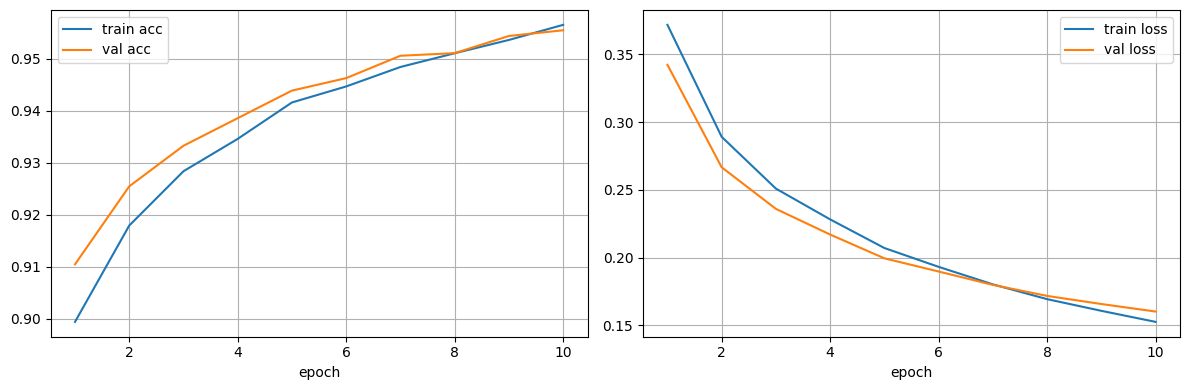

In [88]:
# Load data (set add_bias_in_file=True if your pickle vectors have +1 at the end)
(train_X, train_Y), (val_X, val_Y), (test_X, test_Y) = load_mnist_pickle("mnist.pkl.gz", add_bias_in_file=True)

# Build the network equivalent to 784 -> 30 -> 10 (Task 5 baseline)
mlp = ExtendedMLP(
    layer_sizes=[train_X.shape[1], 30, 10],
    hidden_activation="sigmoid",
    output_activation="softmax",
    loss="cross_entropy",
)

# Train quickly
hist = mlp.fit(train_X, train_Y, epochs=10, batch_size=32, lr=0.1, X_val=val_X, Y_val=val_Y)
print("Test accuracy:", mlp.score(test_X, test_Y))
mlp.plot_history()

## Task 5a: data augmentation via attack___ generate adversarial data → retrain → attack again with a different attack

In [94]:
class AdversarialAttack:
    """Adversarial attacks for the current NeuralNetwork (with bias in input)."""

    @staticmethod
    def input_gradient(model: NeuralNetwork, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Compute dLoss/dx for quadratic loss 0.5||o - y||^2 and sigmoid activations.
        x: (785,) includes trailing bias 1.0; we will not perturb that entry.
        """
        # forward
        h_in, h_with_bias, o_in, o_out = model.feedforward(x)   # shapes: (30,), (31,), (10,), (10,)

        # output delta: dL/dz_out = (o - y) * σ'(z_out)
        delta_out = (o_out - y) * model.sigmoid_derivative(o_in)            # (10,)

        # back to hidden (incl. bias), then drop bias component
        dL_dh_with_bias = model.weights_hidden_output.T @ delta_out          # (31,)
        dL_dh = dL_dh_with_bias[:-1]                                         # (30,) exclude hidden bias

        # hidden delta: dL/dz_hidden = dL/da_hidden * σ'(z_hidden)
        delta_hidden = dL_dh * model.sigmoid_derivative(h_in)                # (30,)

        # finally: dL/dx = W_ih^T @ delta_hidden
        grad_x = model.weights_input_hidden.T @ delta_hidden                 # (785,)
        # do not perturb the bias input
        grad_x[-1] = 0.0
        return grad_x

    @staticmethod
    def fgsm_attack(model: NeuralNetwork, x: np.ndarray, y: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        """True FGSM using sign(∂L/∂x)."""
        g = AdversarialAttack.input_gradient(model, x, y)
        x_adv = x + epsilon * np.sign(g)
        # keep pixel range; skip the bias entry
        x_adv[:-1] = np.clip(x_adv[:-1], 0.0, 1.0)
        x_adv[-1] = 1.0
        return x_adv

    # ------ convenience batch helpers ------
    @staticmethod
    def fgsm_attack_batch(model: NeuralNetwork, X: np.ndarray, Y: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        X_adv = np.empty_like(X)
        for i in range(X.shape[0]):
            X_adv[i] = AdversarialAttack.fgsm_attack(model, X[i], Y[i], epsilon)
        return X_adv

    @staticmethod
    def random_noise_attack(x: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        noise = np.random.normal(0, epsilon, size=x.shape)
        x_noisy = x + noise
        x_noisy[:-1] = np.clip(x_noisy[:-1], 0.0, 1.0)  # keep bias untouched
        x_noisy[-1] = 1.0
        return x_noisy

    @staticmethod
    def random_noise_attack_batch(X: np.ndarray, epsilon: float = 0.1) -> np.ndarray:
        Xn = X + np.random.normal(0, epsilon, size=X.shape)
        Xn[:, :-1] = np.clip(Xn[:, :-1], 0.0, 1.0)
        Xn[:, -1] = 1.0
        return Xn

Baseline (clean-trained) accuracy on clean test: 96.08%
Epoch 01 | Train 65.70% | Val 69.34% | Loss 0.2925 | ValLoss 0.2729
Epoch 02 | Train 78.85% | Val 84.76% | Loss 0.1946 | ValLoss 0.1668
Epoch 03 | Train 85.10% | Val 88.04% | Loss 0.1470 | ValLoss 0.1239
Epoch 04 | Train 86.25% | Val 89.09% | Loss 0.1272 | ValLoss 0.1050
Epoch 05 | Train 86.70% | Val 89.88% | Loss 0.1149 | ValLoss 0.0945
Epoch 06 | Train 86.35% | Val 90.42% | Loss 0.1119 | ValLoss 0.0876
After adversarial augmentation: accuracy on CLEAN test  = 89.90%
After re-attack (random noise, ε=0.12): accuracy   = 89.45%


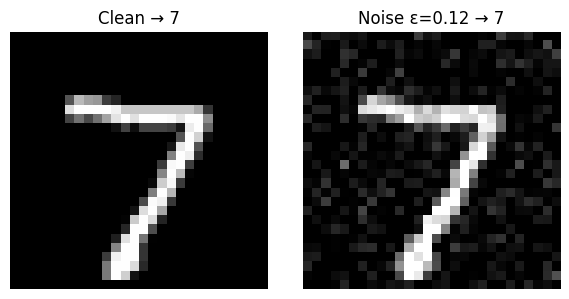

In [95]:
# -------- Task 5: adversarial augmentation & re-attack (different attack) --------

# 1) Pack lists -> arrays
def pack_xy(pairs):
    X = np.stack([p[0] for p in pairs], axis=0)
    Y = np.stack([p[1] for p in pairs], axis=0)
    return X, Y

train_X, train_Y = pack_xy(training_data)
val_X,   val_Y   = pack_xy(validation_data)
test_X,  test_Y  = pack_xy(test_data)

# 2) Baseline (assumes you already trained 'network' on clean data)
baseline_clean_acc = network.evaluate(test_data)
print(f"Baseline (clean-trained) accuracy on clean test: {baseline_clean_acc:.2%}")

# 3) Generate adversarial TRAINING data with FGSM (use modest ε)
eps_train = 0.12
X_adv_train = AdversarialAttack.fgsm_attack_batch(network, train_X, train_Y, epsilon=eps_train)

# 4) Augment and shuffle
X_aug = np.vstack([train_X, X_adv_train])
Y_aug = np.vstack([train_Y, train_Y])

perm = np.random.permutation(X_aug.shape[0])
X_aug, Y_aug = X_aug[perm], Y_aug[perm]

# 5) Retrain a fresh model on augmented data (same architecture/hparams you used)
aug_model = NeuralNetwork(input_size=785, hidden_size=31, output_size=10)
aug_pairs = list(zip(list(X_aug), list(Y_aug)))
val_pairs = validation_data  # unchanged
aug_model.train_sgd(aug_pairs, epochs=6, mini_batch_size=64, learning_rate=0.15, validation_data=val_pairs)

# 6) Evaluate: clean test AND re-attack with a DIFFERENT attack (random noise)
aug_clean_acc = aug_model.evaluate(test_data)
eps_test = 0.12  # use similar strength for a fair robustness check
X_noise_test = AdversarialAttack.random_noise_attack_batch(test_X, epsilon=eps_test)
noise_pairs = list(zip(list(X_noise_test), list(test_Y)))
aug_noise_acc = aug_model.evaluate(noise_pairs)

print(f"After adversarial augmentation: accuracy on CLEAN test  = {aug_clean_acc:.2%}")
print(f"After re-attack (random noise, ε={eps_test}): accuracy   = {aug_noise_acc:.2%}")

# (optional) show one clean vs attacked image and predictions
i = 0
pred_clean = aug_model.predict(test_X[i])
pred_noise = aug_model.predict(X_noise_test[i])
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(test_X[i][:-1].reshape(28,28), cmap='gray');  plt.title(f"Clean → {pred_clean}"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(X_noise_test[i][:-1].reshape(28,28), cmap='gray'); plt.title(f"Noise ε={eps_test} → {pred_noise}"); plt.axis('off')
plt.tight_layout(); plt.show()

## Task 6 — Tiny hyperparameter study (batch size, lr, epochs, hidden width)

In [93]:
from itertools import product
import time

def run_cfg(hid, bs, lr, ep):
    model = ExtendedMLP([train_X.shape[1], hid, 10],
                        hidden_activation="sigmoid",
                        output_activation="softmax",
                        loss="cross_entropy")
    model.fit(train_X, train_Y, epochs=ep, batch_size=bs, lr=lr, X_val=val_X, Y_val=val_Y)
    return {
        "hidden": hid,
        "batch": bs,
        "lr": lr,
        "epochs": ep,
        "val_acc": model.score(val_X, val_Y),
        "test_acc": model.score(test_X, test_Y)
    }

grid = {
    "hidden": [24, 32, 48],
    "batch":  [32, 64],
    "lr":     [0.08, 0.12, 0.18],
    "epochs": [5, 8],
}

results = []
t0 = time.time()
for hid, bs, lr, ep in product(grid["hidden"], grid["batch"], grid["lr"], grid["epochs"]):
    print(f"→ hidden={hid}, batch={bs}, lr={lr}, epochs={ep}")
    results.append(run_cfg(hid, bs, lr, ep))
print(f"Study finished in {time.time()-t0:.1f}s")

# sort by validation accuracy (primary) then test accuracy
results_sorted = sorted(results, key=lambda r:(r["val_acc"], r["test_acc"]), reverse=True)

# pretty print top-5
print("\nTop configs (by val_acc):")
for r in results_sorted[:5]:
    print(f"hidden={r['hidden']:>2}, batch={r['batch']:>2}, lr={r['lr']:.2f}, epochs={r['epochs']:>2}  "
          f"val_acc={r['val_acc']:.2%}, test_acc={r['test_acc']:.2%}")

→ hidden=24, batch=32, lr=0.08, epochs=5
Epoch 01 | Train 89.47% loss 0.4082 | Val 90.49% loss 0.3761
Epoch 02 | Train 91.15% loss 0.3180 | Val 91.98% loss 0.2952
Epoch 03 | Train 92.04% loss 0.2774 | Val 92.69% loss 0.2610
Epoch 04 | Train 92.75% loss 0.2513 | Val 93.33% loss 0.2378
Epoch 05 | Train 93.20% loss 0.2348 | Val 93.67% loss 0.2248
→ hidden=24, batch=32, lr=0.08, epochs=8
Epoch 01 | Train 89.49% loss 0.4037 | Val 90.65% loss 0.3722
Epoch 02 | Train 91.30% loss 0.3145 | Val 91.87% loss 0.2889
Epoch 03 | Train 92.33% loss 0.2740 | Val 92.78% loss 0.2539
Epoch 04 | Train 92.93% loss 0.2500 | Val 93.34% loss 0.2334
Epoch 05 | Train 93.45% loss 0.2328 | Val 93.86% loss 0.2198
Epoch 06 | Train 93.83% loss 0.2182 | Val 94.40% loss 0.2070
Epoch 07 | Train 94.17% loss 0.2073 | Val 94.51% loss 0.1984
Epoch 08 | Train 94.39% loss 0.1983 | Val 94.84% loss 0.1913
→ hidden=24, batch=32, lr=0.12, epochs=5
Epoch 01 | Train 90.46% loss 0.3525 | Val 91.49% loss 0.3250
Epoch 02 | Train 92.22%